In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

BATCH_SIZE = 100
LR = 1e-3
EPOCHS = 10
LATENT_DIM = 2  # Kept low (2) to force heavy compression and make sampling harder
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 60.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.75MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 15.0MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.41MB/s]


In [3]:
# --- 1. Regularized Autoencoder (RAE) ---
class RAE(nn.Module):
    def __init__(self):
        super(RAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, LATENT_DIM) # Deterministic z
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(LATENT_DIM, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid() # Output pixels 0-1
        )

    def forward(self, x):
        x = x.view(-1, 784)
        z = self.encoder(x)
        reconstruction = self.decoder(z)
        return reconstruction, z

In [4]:
# --- 2. Variational Autoencoder (VAE) ---
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder (features)
        self.fc1 = nn.Linear(784, 512)
        self.fc2_mu = nn.Linear(512, LATENT_DIM)    # Mean
        self.fc2_logvar = nn.Linear(512, LATENT_DIM) # Log Variance

        # Decoder
        self.fc3 = nn.Linear(LATENT_DIM, 512)
        self.fc4 = nn.Linear(512, 784)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc2_mu(h1), self.fc2_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std) # Sampling noise
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        x = x.view(-1, 784)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [5]:
def loss_function_rae(recon_x, x):
    # Standard MSE for reconstruction
    return nn.MSELoss()(recon_x, x.view(-1, 784))

def loss_function_vae(recon_x, x, mu, logvar):
  
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    # 2. KL Divergence
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [6]:
def train(model, model_name, optimizer, loss_fn):
    model.train()
    print(f"Training {model_name}...")
    for epoch in range(EPOCHS):
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            optimizer.zero_grad()

            if model_name == "RAE":
                recon_batch, _ = model(data)
                loss = loss_fn(recon_batch, data)
            else: # VAE
                recon_batch, mu, logvar = model(data)
                loss = loss_fn(recon_batch, data, mu, logvar)

            loss.backward()
            total_loss += loss.item()
            optimizer.step()

        print(f"Epoch {epoch+1}: Average Loss = {total_loss / len(train_loader.dataset):.4f}")

In [7]:
def visualize_results(model, model_name):
    model.eval()

    # 1. Get a batch of original images
    images, _ = next(iter(test_loader))
    images = images.to(DEVICE)

    # 2. Get Reconstructions
    with torch.no_grad():
        if model_name == "RAE":
            recon_images, _ = model(images)
        else:
            recon_images, _, _ = model(images)

    # 3. Generate NEW images by sampling z ~ N(0, 1)
    with torch.no_grad():
        z = torch.randn(16, LATENT_DIM).to(DEVICE) # Generate 16 random vectors
        if model_name == "RAE":
            generated_images = model.decoder(z)
        else:
            generated_images = model.decode(z)

    # Move to CPU for plotting
    images = images.cpu().numpy()
    recon_images = recon_images.view(-1, 1, 28, 28).cpu().numpy()
    generated_images = generated_images.view(-1, 1, 28, 28).cpu().numpy()

    # --- Plotting ---
    fig, axes = plt.subplots(3, 8, figsize=(12, 6))
    fig.suptitle(f'Results for {model_name}', fontsize=16)

    # Row 1: Original Images
    for i in range(8):
        axes[0, i].imshow(images[i][0], cmap='gray')
        axes[0, i].axis('off')
    axes[0, 0].set_title("Original", x=-0.5, y=0.5, fontsize=12, ha='right')

    # Row 2: Reconstructed Images
    for i in range(8):
        axes[1, i].imshow(recon_images[i][0], cmap='gray')
        axes[1, i].axis('off')
    axes[1, 0].set_title("Reconstructed", x=-0.5, y=0.5, fontsize=12, ha='right')

    # Row 3: Generated (Sampled) Images
    for i in range(8):
        axes[2, i].imshow(generated_images[i][0], cmap='gray')
        axes[2, i].axis('off')
    axes[2, 0].set_title("Generated (z~N(0,1))", x=-0.5, y=0.5, fontsize=12, ha='right')

    plt.tight_layout()
    plt.show()

Training RAE...
Epoch 1: Average Loss = 0.0005
Epoch 2: Average Loss = 0.0005
Epoch 3: Average Loss = 0.0005
Epoch 4: Average Loss = 0.0005
Epoch 5: Average Loss = 0.0005
Epoch 6: Average Loss = 0.0005
Epoch 7: Average Loss = 0.0005
Epoch 8: Average Loss = 0.0004
Epoch 9: Average Loss = 0.0004
Epoch 10: Average Loss = 0.0004
Training VAE...
Epoch 1: Average Loss = 184.7377
Epoch 2: Average Loss = 164.6915
Epoch 3: Average Loss = 161.0214
Epoch 4: Average Loss = 158.6904
Epoch 5: Average Loss = 156.8983
Epoch 6: Average Loss = 155.5725
Epoch 7: Average Loss = 154.5076
Epoch 8: Average Loss = 153.5812
Epoch 9: Average Loss = 152.8304
Epoch 10: Average Loss = 152.2274


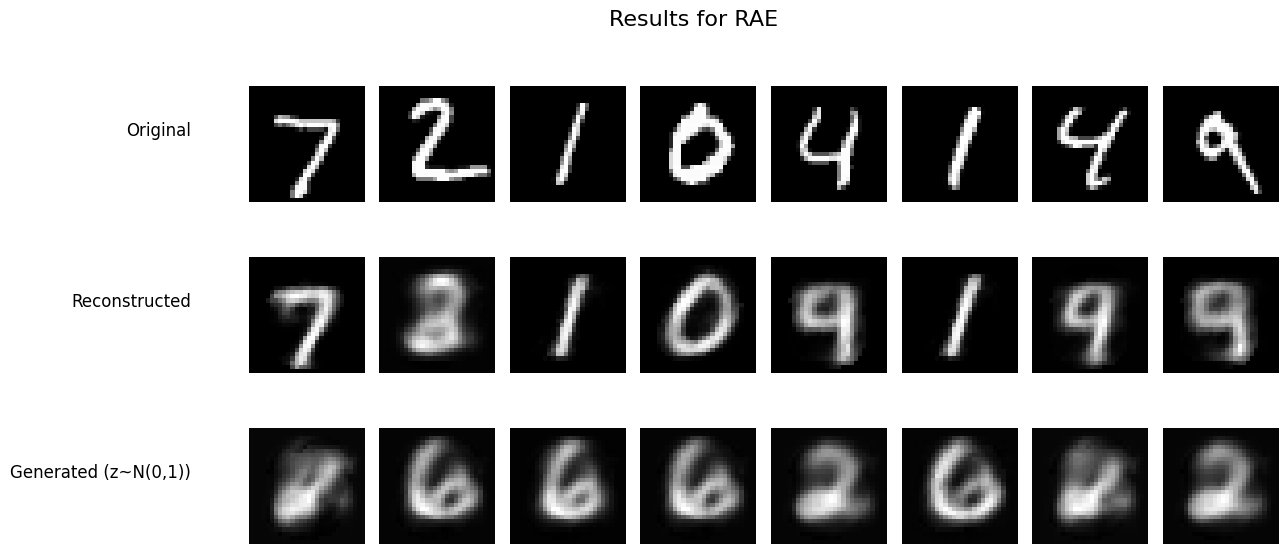

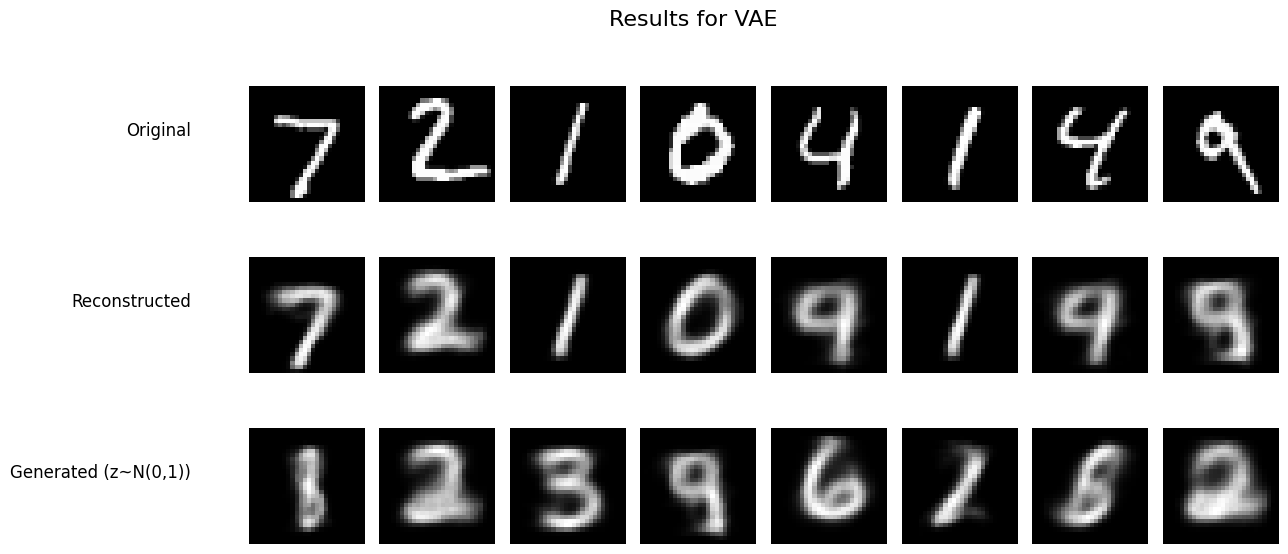

In [8]:
# 1. Train RAE
rae = RAE()
# Weight decay here acts as the "Regularization" in RAE
optimizer_rae = optim.Adam(rae.parameters(), lr=LR, weight_decay=1e-5)
train(rae, "RAE", optimizer_rae, loss_function_rae)

# 2. Train VAE
vae = VAE()
optimizer_vae = optim.Adam(vae.parameters(), lr=LR)
train(vae, "VAE", optimizer_vae, loss_function_vae)

# 3. Visualize
visualize_results(rae, "RAE")
visualize_results(vae, "VAE")